タスクの種類はランキング予測→xgboostで'objective': 'rank:pairwise'とすることで可能、outputは？
→xgboostで設定した項目によりoutputが変わる？
評価指標は仮で正答率もしくはf1scoreにする→xgboostのoutputはどのようになっている？確率で出力されると閾値により判別する必要がある。（６.5は６か7か）
閾値は最適化する必要あり(最適化アルゴリズムもしくは全ての閾値を調べるか)
loglossは(2値分類で正例である確率を予測値)？→なし？→マルチクラスloglossなら出せる
quadratic weightedは？クラス間に順序関係がある場合に使用する、scilitlearnのcohen_kappa_scoreで出力できる →あり

# →xgboostのランク学習のoutputの形次第であるが、quadratic weightedを用いる→xgboostのoutputに合わせる→ランクだから1,2,,,,



In [1]:
import pandas as pd

horse_data = pd.read_csv('horse_data_analyze_hirata/horse_data_20211101.csv')
horse_data=horse_data.sample(frac=1)
horse_data

,race_id,着,枠番,馬番,馬名,性齢,斤量,騎手,単勝,人気,調教師,馬主,レース種類,レースタイプ,天候,馬現体重,馬体重増減,レース距離,馬場,馬場状態
5479,201906050103,6,7,14,アルマス,牡2,52.0,大塚海渡,283.9,15.0,[東]木村哲也,吉田勝己,2歳未勝利,芝右,晴,386,-2,2000,芝,良
13427,201806030401,8,1,2,パルクデラモール,牝3,54.0,ミナリク,4.3,2.0,[東]鹿戸雄一,Ｇ１レーシング,3歳未勝利,ダ右,晴,448,4,1800,ダート,良
8168,202006030108,4,3,3,サイレントクララ,牝4,55.0,ミナリク,43.6,8.0,[東]小手川準,吉田千津,4歳以上1勝クラス,ダ右,曇,498,-6,1800,ダート,良
16428,201806010108,14,3,6,サトノメサイア,牡6,57.0,福永祐一,9.7,4.0,[東]堀宣行,サトミホースカンパニー,4歳以上1000万下,ダ右,晴,538,2,1800,ダート,良
15291,201806020108,8,4,8,スリーミネルバ,牝4,55.0,武士沢友,62.0,8.0,[東]柄崎孝,永井商事,4歳以上500万下,ダ右,晴,448,2,1200,ダート,良
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14301,201806020710,5,7,13,トウカイエントリー,牡7,57.0,蛯名正義,4.4,2.0,[東]栗田徹,内村正則,韓国馬事会杯,ダ右,晴,504,-8,1800,ダート,良
9176,202006020501,15,1,1,マリノインスパイア,牝3,51.0,小林凌大,174.7,15.0,[東]和田雄二,クラウン,3歳未勝利,ダ右,雨,462,0,1200,ダート,稍重
6318,201906050610,5,5,7,タガノファジョーロ,牡3,54.0,鮫島良太,15.1,6.0,[西]角田晃一,八木良司,北総ステークス,ダ右,晴,454,-4,1800,ダート,良
17117,201806050701,1,1,1,アポロチーター,牡2,55.0,石川裕紀,1.2,1.0,[東]岩戸孝樹,アポロサラブレッドクラブ,2歳未勝利,ダ右,曇,516,4,1200,ダート,良


In [2]:
#raceidと着順を削除し、カテゴリ変数のlabelencodingをするだけでベースラインとなる特徴量を作成できる
#ベースラインの特徴量の作成
horse_data_target= pd.DataFrame(horse_data['着'])
horse_data_target_new= horse_data_target.rename(columns={'着':'order'})
horse_data_target_new

,order
5479,6
13427,8
8168,4
16428,14
15291,8
...,...
14301,5
9176,15
6318,5
17117,1


In [3]:
#horse_data_base = horse_data.drop(['着'],axis=1)
#単勝と人気を除去してテスト→これが学習過程が全て1の原因なら回していくたびに学習されるはず
horse_data_base = horse_data.drop(['着','単勝','人気'],axis=1)
horse_data_base

,race_id,枠番,馬番,馬名,性齢,斤量,騎手,調教師,馬主,レース種類,レースタイプ,天候,馬現体重,馬体重増減,レース距離,馬場,馬場状態
5479,201906050103,7,14,アルマス,牡2,52.0,大塚海渡,[東]木村哲也,吉田勝己,2歳未勝利,芝右,晴,386,-2,2000,芝,良
13427,201806030401,1,2,パルクデラモール,牝3,54.0,ミナリク,[東]鹿戸雄一,Ｇ１レーシング,3歳未勝利,ダ右,晴,448,4,1800,ダート,良
8168,202006030108,3,3,サイレントクララ,牝4,55.0,ミナリク,[東]小手川準,吉田千津,4歳以上1勝クラス,ダ右,曇,498,-6,1800,ダート,良
16428,201806010108,3,6,サトノメサイア,牡6,57.0,福永祐一,[東]堀宣行,サトミホースカンパニー,4歳以上1000万下,ダ右,晴,538,2,1800,ダート,良
15291,201806020108,4,8,スリーミネルバ,牝4,55.0,武士沢友,[東]柄崎孝,永井商事,4歳以上500万下,ダ右,晴,448,2,1200,ダート,良
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14301,201806020710,7,13,トウカイエントリー,牡7,57.0,蛯名正義,[東]栗田徹,内村正則,韓国馬事会杯,ダ右,晴,504,-8,1800,ダート,良
9176,202006020501,1,1,マリノインスパイア,牝3,51.0,小林凌大,[東]和田雄二,クラウン,3歳未勝利,ダ右,雨,462,0,1200,ダート,稍重
6318,201906050610,5,7,タガノファジョーロ,牡3,54.0,鮫島良太,[西]角田晃一,八木良司,北総ステークス,ダ右,晴,454,-4,1800,ダート,良
17117,201806050701,1,1,アポロチーター,牡2,55.0,石川裕紀,[東]岩戸孝樹,アポロサラブレッドクラブ,2歳未勝利,ダ右,曇,516,4,1200,ダート,良


In [4]:
#labelencoding
#特徴量を明示的に追加する、足りないものは付け加える必要があるが今回は据え置き
#GBDTでは大小関係が保存される変換は意味がない
#カテゴリ変数を目的関数をもちいて数値変換(targetencoding)も検討材料
from sklearn.preprocessing import LabelEncoder
horse_data_base_label=horse_data_base
for i in range(len(horse_data_base_label.columns)):
    columns = horse_data_base_label.columns[i]
    le = LabelEncoder()
    le.fit(horse_data_base_label[columns])
    horse_data_base_label[columns]=le.transform(horse_data_base_label[columns])
horse_data_base_label


,race_id,枠番,馬番,馬名,性齢,斤量,騎手,調教師,馬主,レース種類,レースタイプ,天候,馬現体重,馬体重増減,レース距離,馬場,馬場状態
5479,878,6,13,370,23,3,51,67,332,3,1,2,12,27,3,1,3
13427,216,0,1,5167,13,5,9,120,1216,11,0,2,43,33,2,0,3
8168,1171,2,2,2340,14,6,9,53,333,13,0,3,68,23,2,0,3
16428,7,2,5,2437,27,10,134,42,42,12,0,2,88,31,2,0,3
15291,91,3,7,3446,14,6,108,73,796,15,0,2,43,31,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14301,165,6,12,4294,28,10,154,76,248,160,0,2,71,21,2,0,3
9176,1116,0,0,6486,13,2,59,38,28,11,0,4,50,29,0,0,1
6318,945,4,6,3741,24,5,171,210,244,90,0,2,46,25,2,0,3
17117,456,0,0,260,23,6,131,61,6,3,0,3,77,33,0,0,3


In [5]:
#GBDTで行うため、標準かは行わない
#次元削減いる？→今の所いらない
#columnsを英語に変更する
#horse_data_base_label=horse_data_base_label.rename(columns={'枠番':'FNumber','馬番':'HNumber','馬名':'HName','性齢':'ageType','斤量':'added_weight','騎手':'jokey','単勝':'odds','人気':'popular','調教師':'trainer','馬主':'horse_orner','レース種類':'race_kinds','レースタイプ':'race_type','天候':'weather','馬現体重':'weight','馬体重増減':'weight_change','レース距離':'race_dis','馬場':'field','馬場状態':'fc'})
horse_data_base_label=horse_data_base_label.rename(columns={'枠番':'FNumber','馬番':'HNumber','馬名':'HName','性齢':'ageType','斤量':'added_weight','騎手':'jokey','調教師':'trainer','馬主':'horse_orner','レース種類':'race_kinds','レースタイプ':'race_type','天候':'weather','馬現体重':'weight','馬体重増減':'weight_change','レース距離':'race_dis','馬場':'field','馬場状態':'fc'})

horse_data_base_label


,race_id,FNumber,HNumber,HName,ageType,added_weight,jokey,trainer,horse_orner,race_kinds,race_type,weather,weight,weight_change,race_dis,field,fc
5479,878,6,13,370,23,3,51,67,332,3,1,2,12,27,3,1,3
13427,216,0,1,5167,13,5,9,120,1216,11,0,2,43,33,2,0,3
8168,1171,2,2,2340,14,6,9,53,333,13,0,3,68,23,2,0,3
16428,7,2,5,2437,27,10,134,42,42,12,0,2,88,31,2,0,3
15291,91,3,7,3446,14,6,108,73,796,15,0,2,43,31,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14301,165,6,12,4294,28,10,154,76,248,160,0,2,71,21,2,0,3
9176,1116,0,0,6486,13,2,59,38,28,11,0,4,50,29,0,0,1
6318,945,4,6,3741,24,5,171,210,244,90,0,2,46,25,2,0,3
17117,456,0,0,260,23,6,131,61,6,3,0,3,77,33,0,0,3


In [6]:
import numpy as np
#queryデータの作成
#queryデータが必要、queryデータはどこからどこまでのデータをひとまとまりとして扱うかを表すデータです。
#raceidごとにレコード数を集計することでqueryデータとする。
#xgboostはrambdamartでquery必要ない？
query_data = horse_data_base_label.groupby('race_id').count()
query_data= query_data.rename(columns={'FNumber':'count'})
query_data=query_data['count']
np.array(query_data)

#query_dataをどのようにxgboostに読み込ませるか。

array([16, 16, 15, ..., 16, 18, 12])

In [26]:
#モデルの作成
#モデルの種類(xgboost)、ハイパーパラメータの指定を行う
#学習データ目的変数を与えて学習させる
#テストデータを与える
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
#テストデータとtrainデータを分割
X_train,X_test,y_train,y_test= train_test_split(horse_data_base_label,horse_data_target_new,test_size = 0.01,random_state=23)

#queryデータ必要なら後で追加する

query_data_test =X_test.groupby('race_id').count()#trqueryデータ作成
query_data_test= query_data_test.rename(columns={'FNumber':'count'})
test_query=np.array(query_data_test['count'])
X_test=X_test.drop(['race_id'],axis=1)
dtest = xgb.DMatrix(X_test,label = y_test)
dtest.set_group(test_query)

scores = []

#クロスバリデーションを行う
#RambdaRankを使用する場合、単純には学習データを分割できません。
#どうやって分割している？
kf = KFold(n_splits =4 , shuffle = True)#, random_state =23)

for tr_idx,va_idx in kf.split(X_train):
    tr_x,va_x = X_train.iloc[tr_idx],X_train.iloc[va_idx]#それぞれに対してqueryデータを作成する,#race_idの除去もここで行う
    query_data_tr = tr_x.groupby('race_id').count()#trqueryデータ作成
    query_data_tr= query_data_tr.rename(columns={'FNumber':'count'})
    tr_query=np.array(query_data_tr['count'])
    query_data_val = va_x.groupby('race_id').count()#val query作成
    query_data_val= query_data_val.rename(columns={'FNumber':'count'})
    va_query=np.array(query_data_val['count'])
    tr_x,va_x = tr_x.drop(['race_id'],axis=1),va_x.drop(['race_id'],axis=1) #tr,valからraceid削除
    tr_y,va_y = y_train.iloc[tr_idx],y_train.iloc[va_idx]
    dtrain = xgb.DMatrix(tr_x,label=tr_y) #特徴量と目的変数をxgboostのデータ構造に変更する
    dtrain.set_group(tr_query)#queryデータをセットする
    dval = xgb.DMatrix(va_x,label = va_y)
    dval.set_group(va_query)#queryデータをセットする
    a=pd.DataFrame(tr_x)
    #モデルのハイパーパラメータの設定
    xgb_params =  {
        'objective': 'rank:pairwise',
        'eta': 0.1,
        'gamma': 0.001,
        'min_child_weight': 0.01,
        'eval_metric':'ndcg',#仮でloglossつけてみた
        
        'max_depth': 200
    }
    watchlist = [(dtrain,'train'),(dval,'eval')]#学習データ、バリデーションデータに対してのスコアをモニタリングする→パラメータの設定とは別のオプション
    evals_result ={}
#モデルの設定→ここで引数に目的関数と評価指標を設定する
    model = xgb.train(xgb_params,dtrain,10,evals = watchlist,evals_result=evals_result)#ealrystoppingを設定する場合はここで行う
#バリデーションデータに対する適合率を出力する→クロスバリデーションに対してはどのように出力する？
#評価指標をどのようにするか。←残課題→loglossで一度行う
    pred = model.predict(dval)
    #score = log_loss(va_y,pred)#評価指標をloglossとする
    #scores = scores.append(score)

#print(np.mean(scores))

#mapで出力されるのは、平均精度(mean average pression)
#なんでmapが1なのか。1とはなにを意味しているのか。→全部正解している
#「Aの正解数／Aのデータ数」というようにカテゴリ毎に精度を計算し足してカテゴリ数
#→データの作り方が間違っている？
#evalsで設定された項目は何を基準にしている？xとyか？

#NDCG：正規化された割引累積ゲイン

[0]	train-ndcg:0.76750	eval-ndcg:0.77024
[1]	train-ndcg:0.84324	eval-ndcg:0.77877
[2]	train-ndcg:0.88261	eval-ndcg:0.77994
[3]	train-ndcg:0.91062	eval-ndcg:0.78839
[4]	train-ndcg:0.93094	eval-ndcg:0.79204
[5]	train-ndcg:0.94808	eval-ndcg:0.79688
[6]	train-ndcg:0.95578	eval-ndcg:0.79955
[7]	train-ndcg:0.95993	eval-ndcg:0.79945
[8]	train-ndcg:0.96730	eval-ndcg:0.80141
[9]	train-ndcg:0.96962	eval-ndcg:0.80322
[0]	train-ndcg:0.77782	eval-ndcg:0.76384
[1]	train-ndcg:0.85734	eval-ndcg:0.77409
[2]	train-ndcg:0.89881	eval-ndcg:0.77907
[3]	train-ndcg:0.92080	eval-ndcg:0.78228
[4]	train-ndcg:0.93576	eval-ndcg:0.78246
[5]	train-ndcg:0.94505	eval-ndcg:0.78853
[6]	train-ndcg:0.95539	eval-ndcg:0.79212
[7]	train-ndcg:0.96311	eval-ndcg:0.79202
[8]	train-ndcg:0.96864	eval-ndcg:0.79517
[9]	train-ndcg:0.97146	eval-ndcg:0.79689
[0]	train-ndcg:0.76619	eval-ndcg:0.76629
[1]	train-ndcg:0.84776	eval-ndcg:0.77027
[2]	train-ndcg:0.89626	eval-ndcg:0.77811
[3]	train-ndcg:0.92227	eval-ndcg:0.78163
[4]	train-ndcg:0

In [27]:
a

,FNumber,HNumber,HName,ageType,added_weight,jokey,trainer,horse_orner,race_kinds,race_type,weather,weight,weight_change,race_dis,field,fc
7830,0,1,6197,30,10,113,108,381,88,0,4,80,37,2,0,0
2684,7,9,580,24,5,145,103,375,5,3,3,62,23,1,1,1
7486,4,9,691,24,8,22,81,10,11,3,3,55,27,4,1,3
7571,3,6,1088,25,10,105,69,637,14,0,3,64,35,0,0,3
13073,5,10,7216,13,5,44,23,32,11,0,3,39,29,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14777,3,5,6793,24,8,31,113,965,11,0,3,65,23,0,0,3
13463,7,12,6428,5,10,28,110,1215,15,0,2,44,29,2,0,1
7679,4,5,6265,24,8,115,112,45,11,0,4,57,31,2,0,0
2464,2,2,7905,13,5,166,219,535,11,0,3,54,25,2,0,3


In [28]:
pred

array([0.32582104, 0.7940453 , 0.5258493 , ..., 0.5223257 , 0.3958286 ,
       0.3619752 ], dtype=float32)

In [16]:
pred_test = model.predict(dtest)
pred_test = pd.DataFrame(pred_test)
y_test = pd.DataFrame(y_test)
#y_test= y_test.reset_index(inplace = True)

In [17]:
y_test=y_test.reset_index()
y_test= y_test.drop(['index'],axis=1)
y_test

,order
0,7
1,14
2,2
3,2
4,11
...,...
177,5
178,3
179,9
180,3


In [18]:
pred_test

,0
0,0.265421
1,0.835171
2,0.040729
3,0.663141
4,0.816094
...,...
177,0.505215
178,0.221036
179,0.700323
180,0.859784


In [19]:
concat_test = pd.concat([y_test,pred_test],axis=1)
#concat_test= concat_test.set_axis(['着','予測'],axis=1)
concat_test
#なんとなく予測できている気がする
#順位が高いものが数値が低くなっている

,order,0
0,7,0.265421
1,14,0.835171
2,2,0.040729
3,2,0.663141
4,11,0.816094
...,...,...
177,5,0.505215
178,3,0.221036
179,9,0.700323
180,3,0.859784


In [20]:
concat_test= concat_test.set_axis(['着','予測'],axis=1)
concat_test

,着,予測
0,7,0.265421
1,14,0.835171
2,2,0.040729
3,2,0.663141
4,11,0.816094
...,...,...
177,5,0.505215
178,3,0.221036
179,9,0.700323
180,3,0.859784


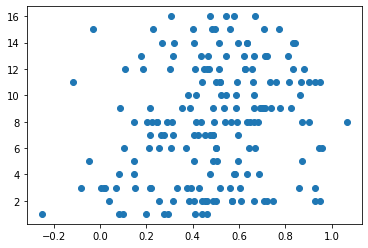

In [21]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
ax.scatter(concat_test['予測'],concat_test['着'])

plt.show()
#なんとなく予測できている気がする
#着と単勝抜いたらほぼ予測できていない

# 課題
まず学習を成立させる
→学習が進んでいない（ずっと学習の進捗度が1になっている）
→単勝、人気を除外すると、ほとんど学習ができていない
(入れた方がいいとは思うがどのタイミングで表示されるかによっては入れることができない)
# 疑問点
・outputの数値ってなに？
→目的関数の値？→順位に変換するならraceごとに小さい順にソートして順位をつける必要がある?
//学習データの評価用の指標→eval_metric(or metric)で指定できる→defaultはobjectiveに依存する？→pairwise関数が出力に当たる
rank:pairwise→rank:ランキング学習する。pairwise:ペアワイズ損失が最小化されるペアワイズランキングを実行します(目的関数)
xgboostのデフォルトのoutputはどのような形か。
↑とrankでは異なるのか。
xgboost:
予測値を予測確率に変換して使用する　　　　　　　　
pairwise:kendollの順位相関



・ただどうやって評価する？
　　順位が当たる確率？
レースごとにバリデーションするべきでは？
・予測精度を評価したい
・学習がどの程度進んでいるかモニタリングしたい

・evalsの出力がtrain,valどちらもずっと1なのは何故？
何が1なのか
→目的関数に応じた評価指標
watchlistって何をみたらいいの？=引数のevalって何をみて何を出力しているの？(eval_map,train_map)
→本来なら学習とともに下がっていくはず、いまのoutput見ると別にkfoldする必要もなく、繰り返す必要もない
学習用データセットでの誤差評価、右側のevalが検証用データセットでの誤差評価です。(真値と測定値の差)
「train-map」のmapに意味がある？

→おそらく、全く学習ができていないと思われる。
どのようにするか。

# 改善方針
単勝と人気を抜いたら精度がめっちゃ下がる気がする
例：馬ごとの過去のレースをレコードにしていた
方針
→特徴量のパラメータをいじることとする。
→データも足りていない？


In [71]:
pd.DataFrame(pred_test)

,0
0,0.499717
1,0.500111
2,0.499877
3,0.500257
4,0.500301
...,...
177,0.500169
178,0.499869
179,0.500314
180,0.499558


KeyError: 'eval'

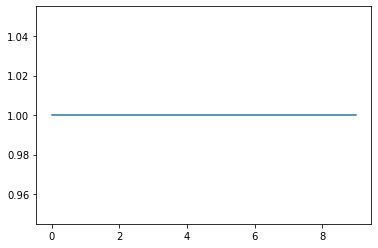

In [72]:
#学習過程の可視化の工程
train_metric = evals_result['train']['map']#['logloss']
plt.plot(train_metric, label='train learning')
eval_metric = evals_result['eval']['map']#['logloss']
plt.plot(eval_metric, label='eval learning')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('learning')
plt.show()


In [73]:
evals_result

{'train': OrderedDict([('map',
               [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])]),
 'validation': OrderedDict([('map',
               [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])])}

In [32]:
a=[]
b=[]
for i,y in kf.split(X_train):
    a.append(i)
    b.append(y)

In [38]:
pd.DataFrame(a[0])

,0
0,1
1,2
2,3
3,4
4,5
...,...
13499,17999
13500,18000
13501,18003
13502,18004


In [39]:
pd.DataFrame(a[1])

,0
0,0
1,3
2,4
3,5
4,6
...,...
13499,17999
13500,18001
13501,18002
13502,18003


In [43]:
pd.DataFrame(a[2])

,0
0,0
1,1
2,2
3,5
4,6
...,...
13500,18000
13501,18001
13502,18002
13503,18004


In [44]:
ka = KFold(n_splits =4 , shuffle = True)

a=[]
b=[]
for i,y in ka.split(X_train):
    a.append(i)
    b.append(y)

In [45]:
a

[array([    0,     1,     2, ..., 18002, 18004, 18005]),
 array([    0,     1,     2, ..., 18003, 18004, 18005]),
 array([    2,     3,     4, ..., 18000, 18001, 18003]),
 array([    0,     1,     3, ..., 18003, 18004, 18005])]